In [1]:
import deepxde as dde
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from naca4digit_airfoil import Naca4DigitAirfoil
from navier_stokes_with_data import NavierStokesPDEs
import utils
import pandas as pd
from scipy.interpolate import griddata

/Users/ggito/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
cfd_df = pd.read_csv('NACA2412.txt', delimiter=',')

In [3]:
x_min = -0.5
x_max = 2
y_min = -1
y_max = 1

In [4]:
# sf_xy = max(abs(cfd_df.x).max(), abs(cfd_df.y).max())
sf_xy = max(x_max - x_min, y_max - y_min)
sf_uv = max(abs(cfd_df.u).max(), abs(cfd_df.v).max())
sf_p = abs(cfd_df).p.max()

In [5]:
x_min_scaled = x_min / sf_xy
x_max_scaled = x_max / sf_xy
y_min_scaled = y_min / sf_xy
y_max_scaled = y_max / sf_xy

In [6]:
dde.config.set_random_seed(48)
dde.config.set_default_float('float64')

rho  = 1.225
mu   = 1.81e-5
# u_in  = 15
# u_in  = 1

Set the default float type to float64


In [7]:
airfoil = Naca4DigitAirfoil(c=1/sf_xy, M=2, P=4, T=12, a=0, offset_x=0, offset_y=0)

In [8]:
# Geometry defintion
farfield = dde.geometry.Rectangle([x_min_scaled, y_min_scaled], [x_max_scaled, y_max_scaled])
airfoil_geom  = dde.geometry.Polygon(airfoil.get_boundary_points(250))
geom     = dde.geometry.CSGDifference(farfield, airfoil_geom)

# inner_rec  = dde.geometry.Rectangle([-0.1, -0.1], [0.1, 0.1])
inner_rec  = dde.geometry.Rectangle([-0.5/sf_xy, -0.5/sf_xy], [0.5/sf_xy, 0.5/sf_xy])
# inner_rec  = dde.geometry.Rectangle([-0.05, -0.05], [0.05, 0.05])

inner_dom  = dde.geometry.CSGDifference(inner_rec, airfoil_geom)

outer_dom  = dde.geometry.CSGDifference(farfield, inner_rec)
outer_dom  = dde.geometry.CSGDifference(outer_dom, airfoil_geom)

In [20]:
Nf1 = 2**15 # = 32768
Nf2 = 2**16 # = 65536
Nb  = 2**11 # = 2048
Ns  = 250

random = "Sobol"
inner_points = inner_dom.random_points(Nf1, random=random)
outer_points = outer_dom.random_points(Nf2, random=random)

farfield_points = farfield.random_boundary_points(Nb, random=random)
airfoil_points  = airfoil.get_boundary_points(Ns)

points = np.append(inner_points, outer_points, axis = 0)
# points = np.append(points, farfield_points, axis = 0)
points = np.append(points, airfoil_points, axis = 0)

(-0.5, 0.5)

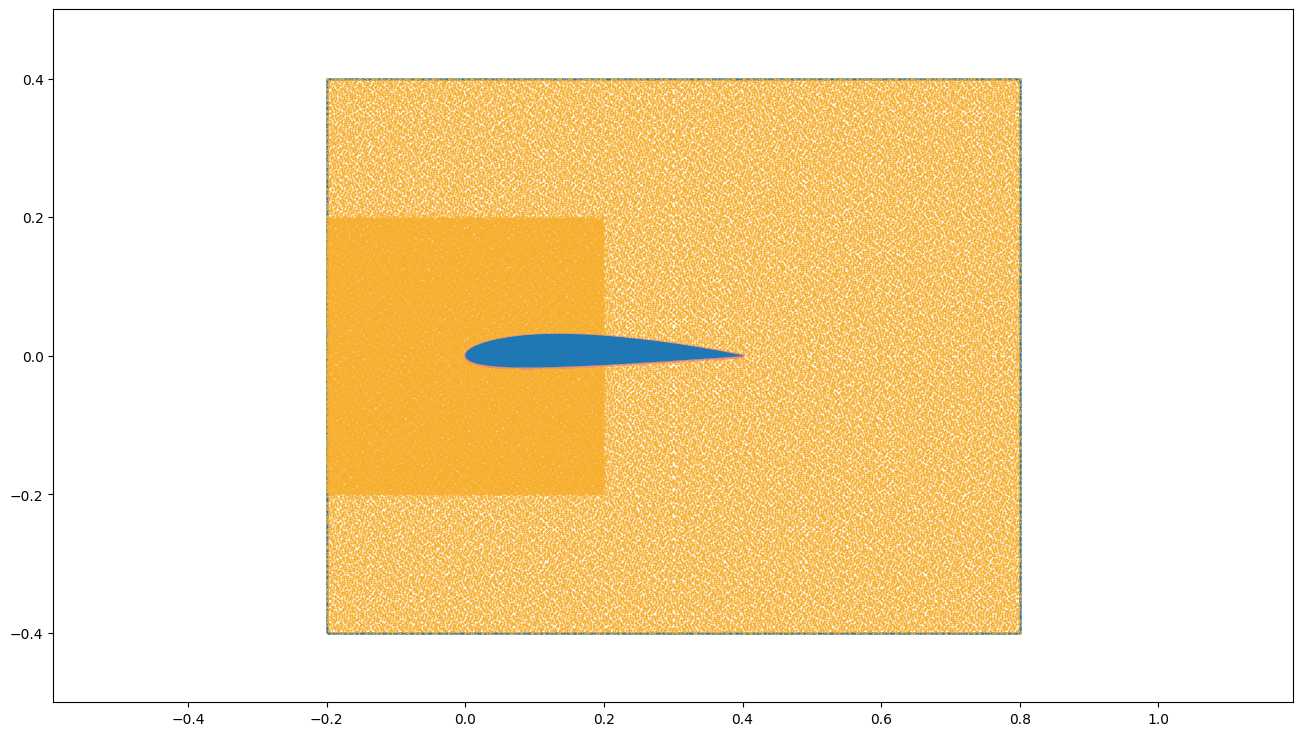

In [21]:
fig1, ax1 = plt.subplots(figsize = (16, 9))
plt.axis('equal')
plt.scatter(farfield_points[:, 0], farfield_points[:, 1], s = 0.5, c='#40798C')  # Ocean blue for farfield points
plt.scatter(inner_points[:, 0], inner_points[:, 1], s = 0.5, c = '#F6AE2D')  # Sunflower yellow for inner points
plt.scatter(outer_points[:, 0], outer_points[:, 1], s = 0.5, c = '#F6AE2D')  # Sunflower yellow for outer points
plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = '#E9897E')  # Sunset coral for airfoil points
plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
plt.xlim([x_min_scaled - 0.1, x_max_scaled + 0.1])
plt.ylim([y_min_scaled - 0.1, y_max_scaled + 0.1])

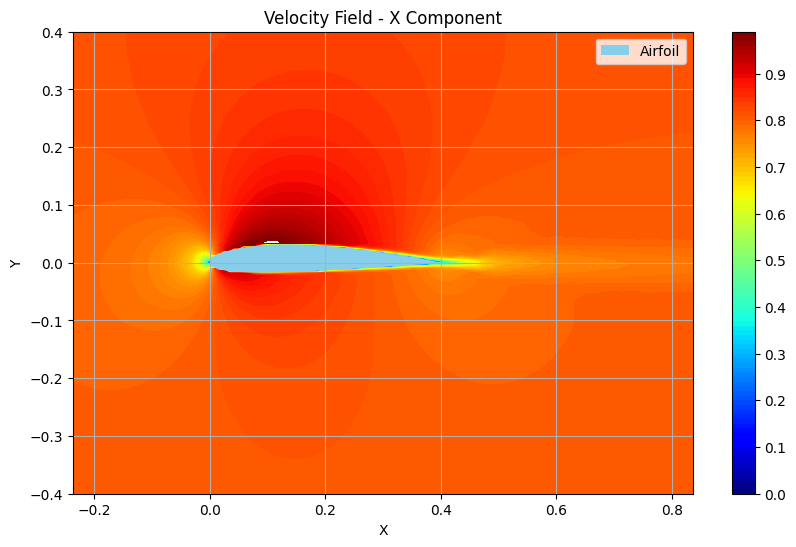

In [22]:
X, Y = np.meshgrid(np.linspace(cfd_df['x'].min() / sf_xy, cfd_df['x'].max() / sf_xy, 1000),
                             np.linspace(cfd_df['y'].min() / sf_xy, cfd_df['y'].max() / sf_xy, 1000))

U = griddata((cfd_df['x'] / sf_xy, cfd_df['y'] / sf_xy), cfd_df['u'] / sf_uv, (X, Y), method='linear')

fig, ax = plt.subplots(figsize=(10, 6))

clev = np.arange(U.min(), U.max(), 0.01)
cp = ax.contourf(X, Y, U, clev, cmap='jet')
fig.colorbar(cp, ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Velocity Field - X Component')
airfoil.plot(ax)
ax.set_xlim(x_min_scaled, x_max_scaled)
ax.set_ylim(y_min_scaled, y_max_scaled)
# ax.set_xlim(cfd_df['x'].min() / sf_xy, cfd_df['x'].max() / sf_xy)
# ax.set_ylim(cfd_df['y'].min() / sf_xy, cfd_df['y'].max() / sf_xy)
plt.show()

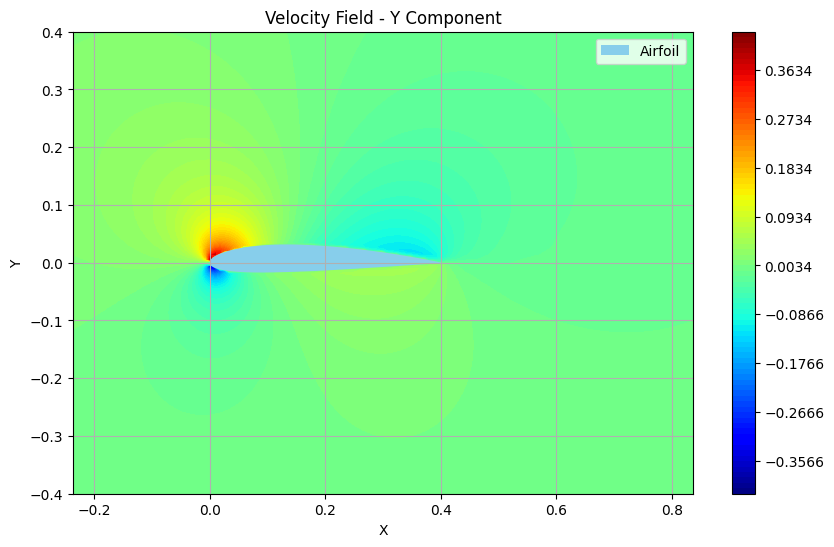

In [12]:
V = griddata((cfd_df['x'] / sf_xy, cfd_df['y'] / sf_xy), cfd_df['v'] / sf_uv, (X, Y), method='linear')

fig, ax = plt.subplots(figsize=(10, 6))

clev = np.arange(V.min(), V.max(), 0.01)
cp = ax.contourf(X, Y, V, clev, cmap='jet')
fig.colorbar(cp, ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Velocity Field - Y Component')
airfoil.plot(ax)
ax.set_xlim(x_min_scaled, x_max_scaled)
ax.set_ylim(y_min_scaled, y_max_scaled)
# ax.set_xlim(cfd_df['x'].min() / sf_xy, cfd_df['x'].max() / sf_xy)
# ax.set_ylim(cfd_df['y'].min() / sf_xy, cfd_df['y'].max() / sf_xy)
plt.show()

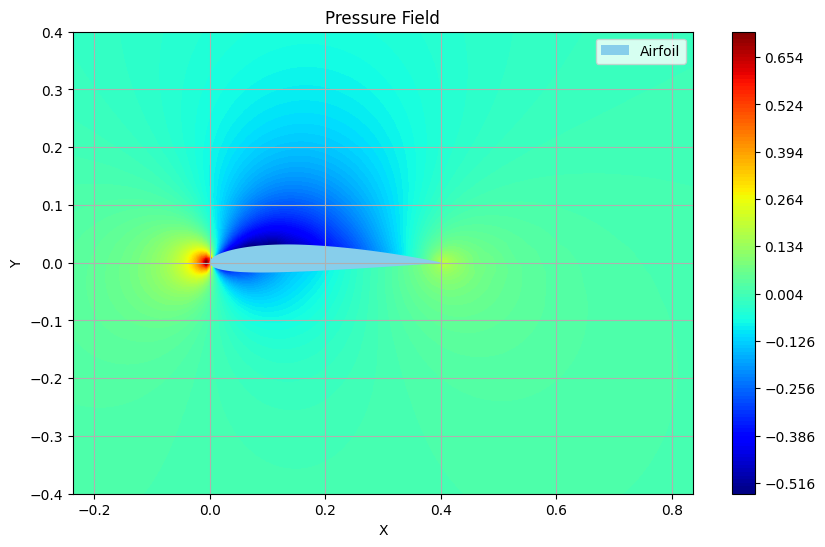

In [13]:
P = griddata((cfd_df['x'] / sf_xy, cfd_df['y'] / sf_xy), cfd_df['p'] / sf_p, (X, Y), method='linear')

fig, ax = plt.subplots(figsize=(10, 6))

clev = np.arange(P.min(), P.max(), 0.01)
cp = ax.contourf(X, Y, P, clev, cmap='jet')
fig.colorbar(cp, ax=ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Pressure Field')
airfoil.plot(ax)
ax.set_xlim(x_min_scaled, x_max_scaled)
ax.set_ylim(y_min_scaled, y_max_scaled)
# ax.set_xlim(cfd_df['x'].min() / sf_xy, cfd_df['x'].max() / sf_xy)
# ax.set_ylim(cfd_df['y'].min() / sf_xy, cfd_df['y'].max() / sf_xy)
plt.show()

In [23]:
x_data = farfield_points[:, 0]
y_data = farfield_points[:, 1]

grid_points = cfd_df[['x', 'y']].values / sf_xy
u_values = cfd_df['u'].values / sf_uv
v_values = cfd_df['v'].values / sf_uv
p_values = cfd_df['p'].values / sf_p

u_interp = griddata(grid_points, u_values, (x_data, y_data), method='linear')
v_interp = griddata(grid_points, v_values, (x_data, y_data), method='linear')
p_interp = griddata(grid_points, p_values, (x_data, y_data), method='linear')

uvp_data = np.vstack((u_interp, v_interp, p_interp)).T

u_data = np.array([uvp_data[i][0] for i in range(len(uvp_data))])
v_data = np.array([uvp_data[i][1] for i in range(len(uvp_data))])
p_data = np.array([uvp_data[i][2] for i in range(len(uvp_data))])

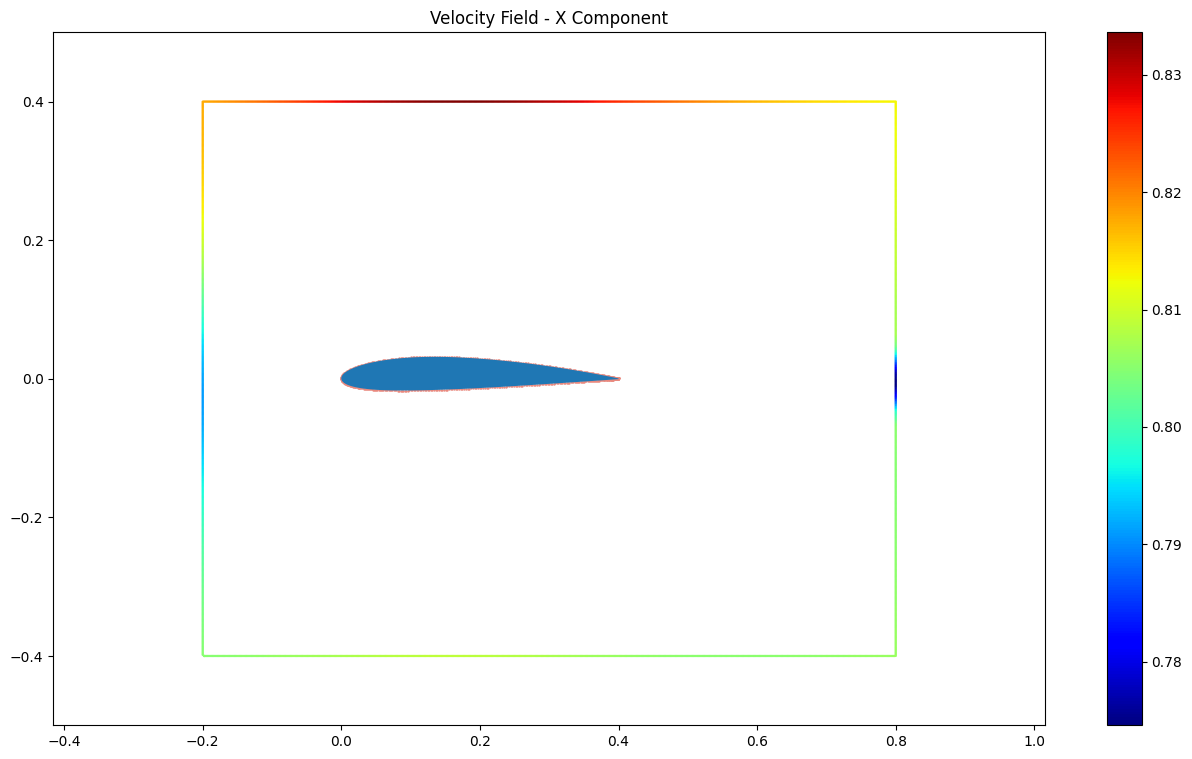

In [15]:
fig1, ax1 = plt.subplots(figsize = (16, 9))
plt.axis('equal')
scatter = plt.scatter(x_data, y_data, c=u_data, s=0.5, cmap='jet')
plt.colorbar(scatter)
plt.title('Velocity Field - X Component')
plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = '#E9897E')  # Sunset coral for airfoil points
plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
plt.xlim([x_min_scaled - 0.1, x_max_scaled + 0.1])
plt.ylim([y_min_scaled - 0.1, y_max_scaled + 0.1])
plt.show()

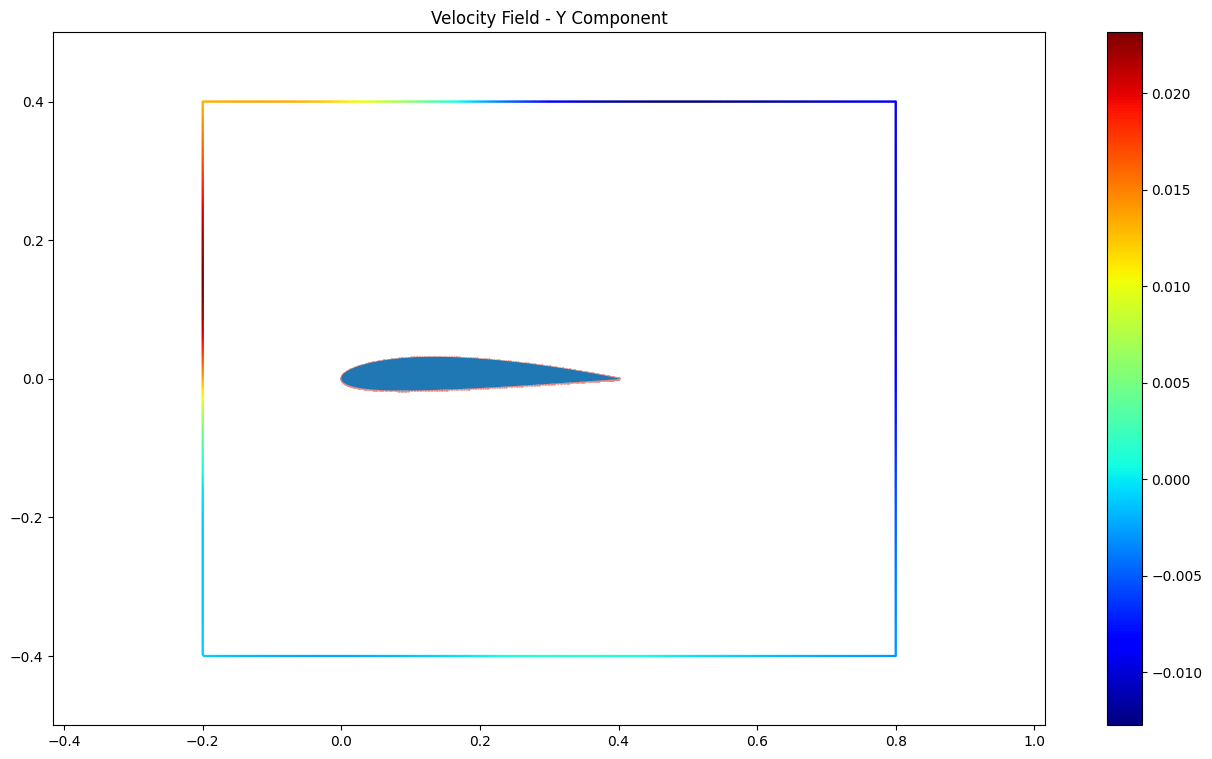

In [16]:
fig1, ax1 = plt.subplots(figsize = (16, 9))
plt.axis('equal')
scatter = plt.scatter(x_data, y_data, c=v_data, s=0.5, cmap='jet')
plt.colorbar(scatter)
plt.title('Velocity Field - Y Component')
plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = '#E9897E')  # Sunset coral for airfoil points
plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
plt.xlim([x_min_scaled - 0.1, x_max_scaled + 0.1])
plt.ylim([y_min_scaled - 0.1, y_max_scaled + 0.1])
plt.show()

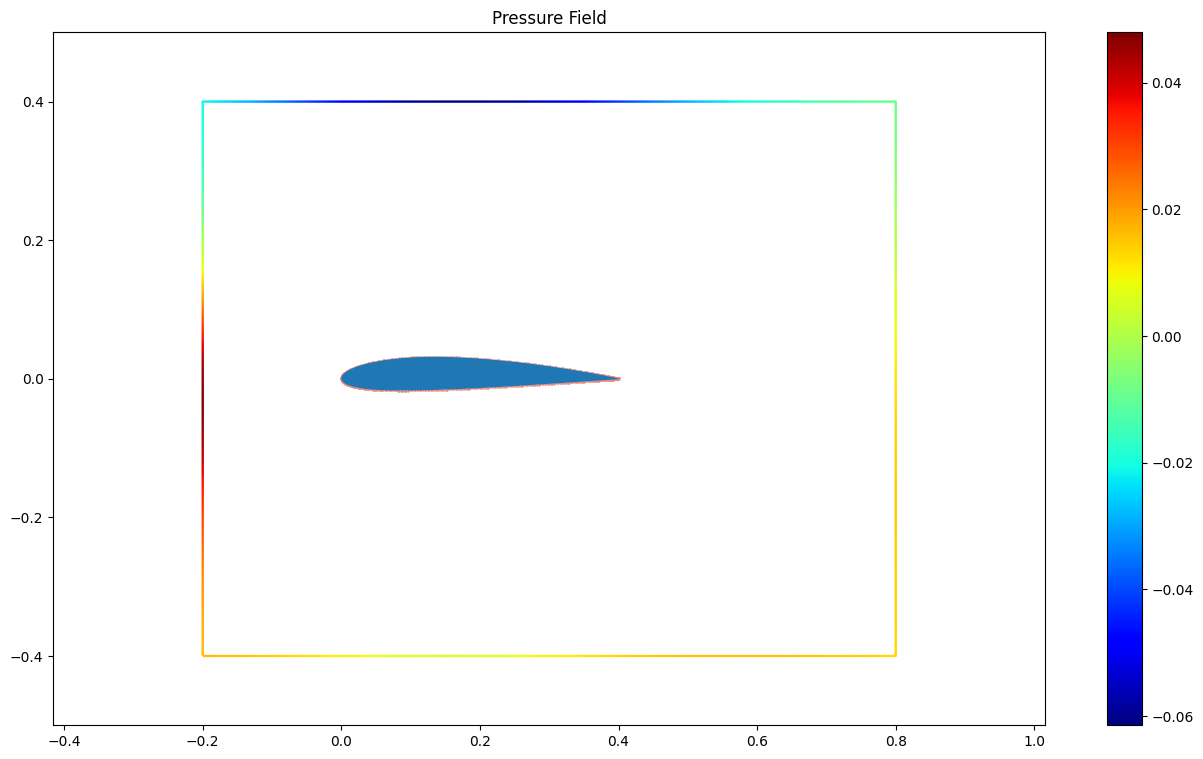

In [17]:
fig1, ax1 = plt.subplots(figsize = (16, 9))
plt.axis('equal')
scatter = plt.scatter(x_data, y_data, c=p_data, s=0.5, cmap='jet')
plt.colorbar(scatter)
plt.title('Pressure Field')
plt.scatter(airfoil_points[:, 0], airfoil_points[:, 1], s = 0.5, c = '#E9897E')  # Sunset coral for airfoil points
plt.fill(airfoil_points[:, 0], airfoil_points[:, 1])
plt.xlim([x_min_scaled - 0.1, x_max_scaled + 0.1])
plt.ylim([y_min_scaled - 0.1, y_max_scaled + 0.1])
plt.show()

In [24]:
navier_stokes_pdes = NavierStokesPDEs(rho=rho, mu=mu,
                                      xmin=x_min_scaled, xmax=x_max_scaled, ymin=y_min_scaled, ymax=y_max_scaled,
                                      airfoil_geom=airfoil_geom, geom=geom,
                                      x_data=x_data, y_data=y_data, u_data=u_data, v_data=v_data, p_data=p_data)

pdes_fun = navier_stokes_pdes.get_pdes
bcs = navier_stokes_pdes.get_bcs()

In [25]:
# Problem setup
data = dde.data.PDE(geom, pdes_fun, bcs, num_domain = 0, num_boundary = 0, num_test = 5000, anchors = points)

dde.config.set_default_float('float64')

Set the default float type to float64


(-0.2499864196777344,
 0.8499833679199219,
 -0.43998657226562504,
 0.439986572265625)

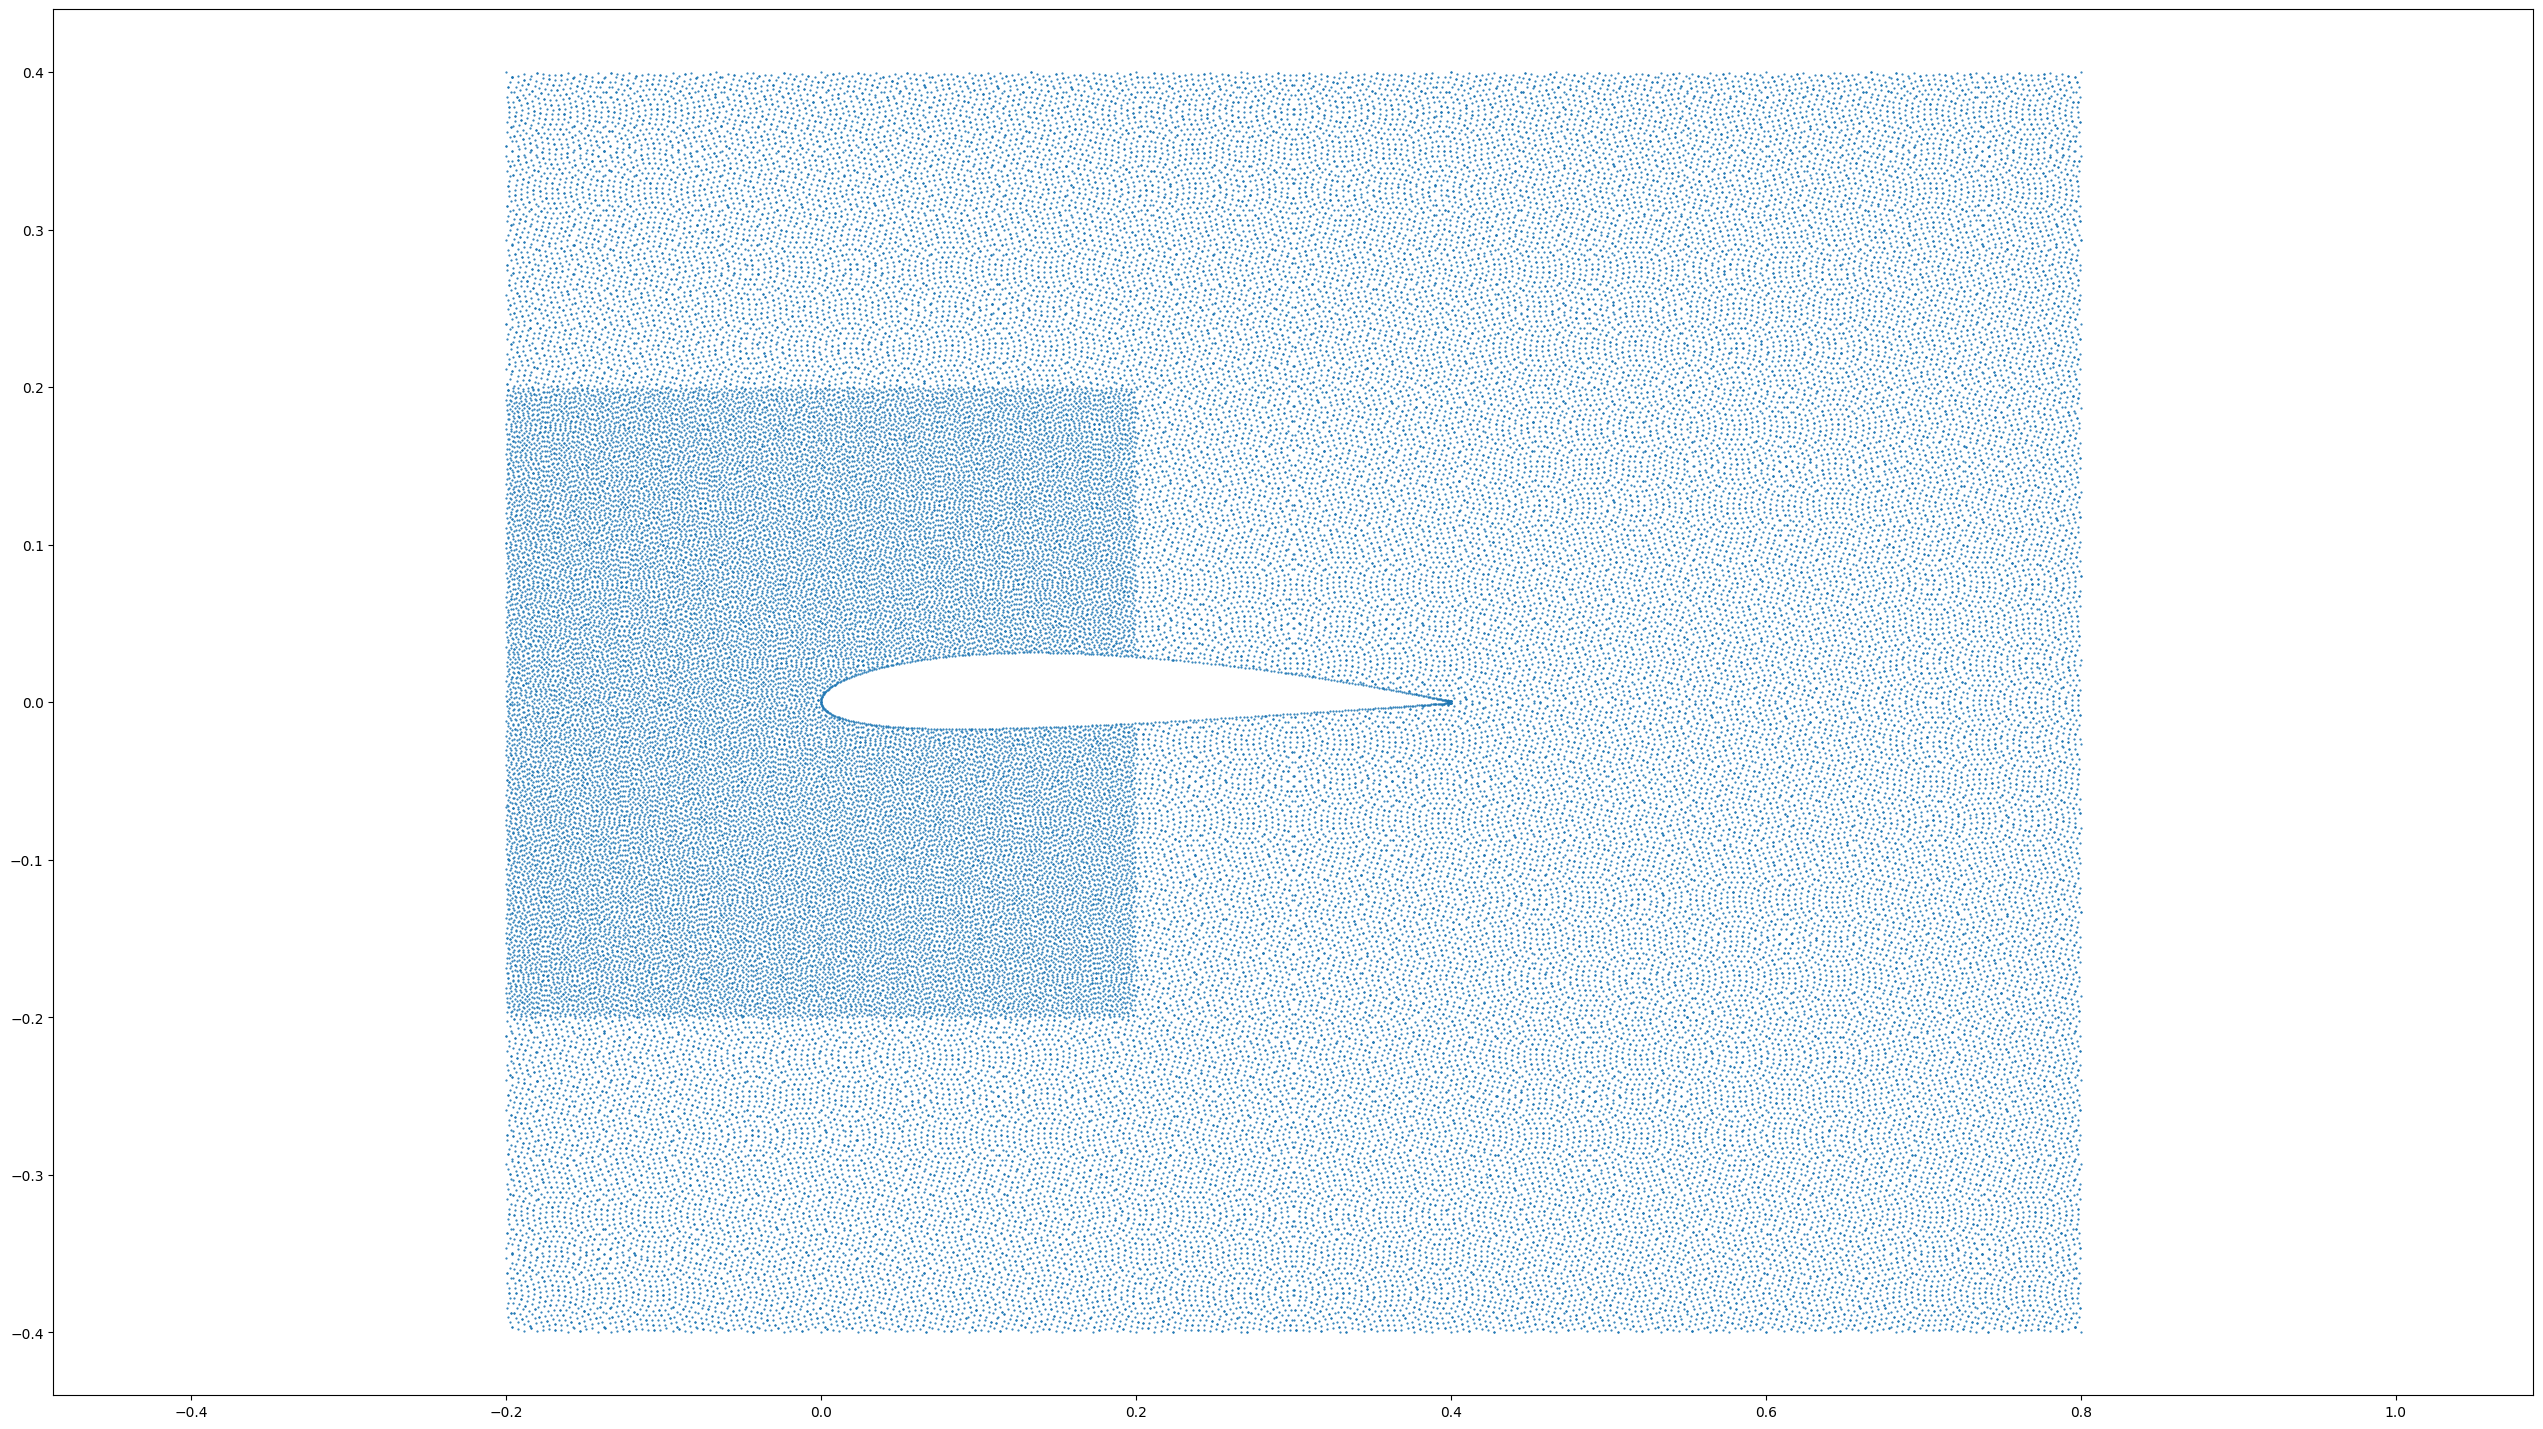

In [26]:
plt.figure(figsize = (32, 18))
plt.scatter(data.train_x_all[:,0], data.train_x_all[:,1], s = 0.3)
plt.axis('equal')

In [28]:
# Neural network definition
layer_size  = [2] + [32] * 10 + [5]
# activation  = 'silu' 
activation  = 'tanh' 
initializer = 'Glorot uniform'

net = dde.nn.FNN(layer_size, activation, initializer)

# Model definition
model = dde.Model(data, net)

In [43]:
name_generator = utils.NameGenerator()
model_name = name_generator.generate_name()
model_name

'AtmosElegantGalaxy375'

In [44]:
# model.compile(optimizer = 'adam', lr = 5e-4, loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2]) # Giving more weight to bcs
model.compile(optimizer = 'adam', lr = 5e-4)

Compiling model...
'compile' took 0.003304 s



Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
20000     [1.56e-03, 2.50e-04, 7.30e-05, 1.11e-04, 1.98e-04, 1.53e-05, 4.58e-04, 6.64e-04, 7.44e-05, 6.22e-04, 2.12e-04]    [1.02e-03, 1.98e-04, 6.07e-05, 1.17e-04, 1.53e-04, 1.61e-05, 4.58e-04, 6.64e-04, 7.44e-05, 6.22e-04, 2.12e-04]    []  
20100     [1.34e-03, 2.64e-04, 6.86e-05, 1.13e-04, 1.90e-04, 2.00e-05, 6.53e-04, 7.07e-04, 6.81e-05, 5.77e-04, 1.90e-04]    [8.83e-04, 2.07e-04, 5.79e-05, 1.18e-04, 1.48e-04, 2.14e-05, 6.53e-04, 7.07e-04, 6.81e-05, 5.77e-04, 1.90e-04]    []  
20200     [3.99e-04, 3.19e-04, 6.44e-05, 9.29e-05, 1.93e-04, 1.65e-05, 8.16e-04, 6.88e-04, 8.92e-05, 7.84e-04, 1.73e-04]    [3.21e-04, 2.42e-04, 5.44e-05, 9.53e-05, 1.56e-04, 1.71e-05, 8.16e-04, 6.88e-04, 8.92e-05, 7.84e-04, 1.73e-04]    []  
20

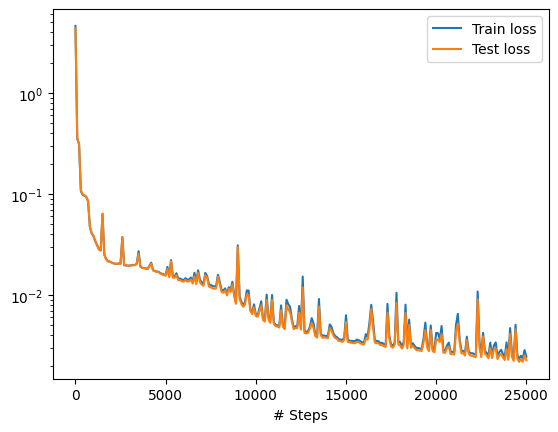

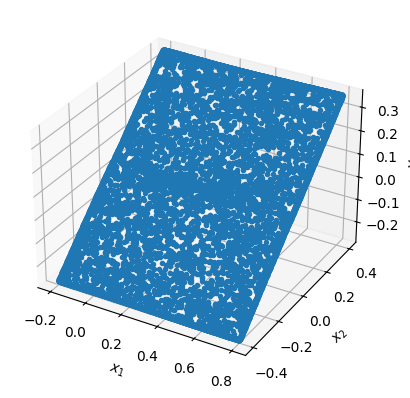

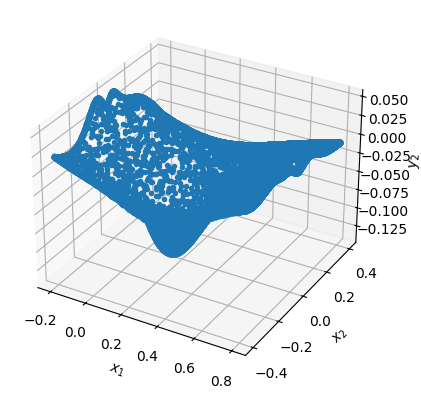

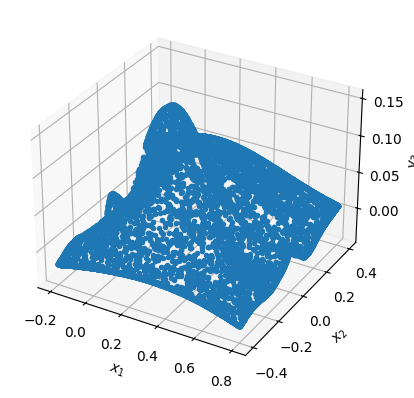

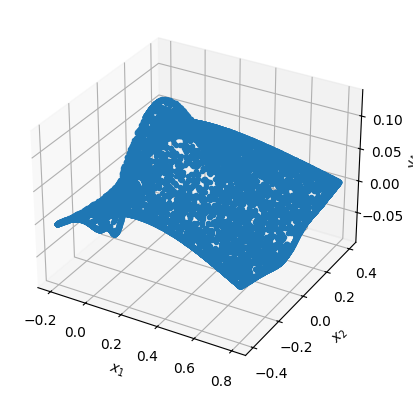

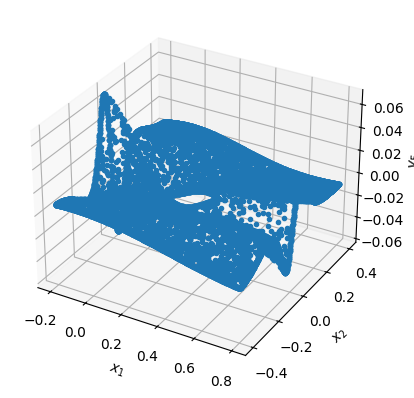

In [59]:
try:
  losshistory, train_state = model.train(epochs = 5000, display_every = 100, model_save_path = './' + model_name + '/')
  dde.saveplot(losshistory, train_state, issave = True, isplot = True)

except KeyboardInterrupt:
  print(f"Training stopped by user.")
  print("=======================================================")

In [65]:
# # model.compile(optimizer = 'L-BFGS-B', loss_weights = [1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])
# model.compile(optimizer = 'L-BFGS-B')
# model.train_step.optimizer_kwargs = {'options': {'maxcor': 50, 
#                                                    'ftol': 1.0 * np.finfo(float).eps, 
#                                                    'maxfun':  50000, 
#                                                    'maxiter': 50000, 
#                                                    'maxls': 50}}

# losshistory, train_state = model.train(display_every = 1, model_save_path = './')
# dde.saveplot(losshistory, train_state, issave = True, isplot = True)

Compiling model...
'compile' took 0.024593 s

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
25000     [4.61e-04, 1.76e-04, 6.16e-05, 9.69e-05, 1.55e-04, 1.20e-05, 2.88e-04, 5.31e-04, 6.95e-05, 4.65e-04, 1.39e-04]    [3.57e-04, 1.33e-04, 4.79e-05, 9.96e-05, 1.17e-04, 1.32e-05, 2.88e-04, 5.31e-04, 6.95e-05, 4.65e-04, 1.39e-04]    []  


KeyboardInterrupt: 

In [ ]:
# model.restore('./-10000.ckpt.index')

In [62]:
# Plotting tool: thanks to @q769855234 code snippet
dx = 0.01
dy = 0.01
x = np.arange(x_min_scaled, x_max_scaled + dy, dx)
y = np.arange(y_min_scaled, y_max_scaled + dy, dy)

X = np.zeros((len(x)*len(y), 2))
xs = np.vstack((x,)*len(y)).reshape(-1)
ys = np.vstack((y,)*len(x)).T.reshape(-1)
X[:, 0] = xs
X[:, 1] = ys

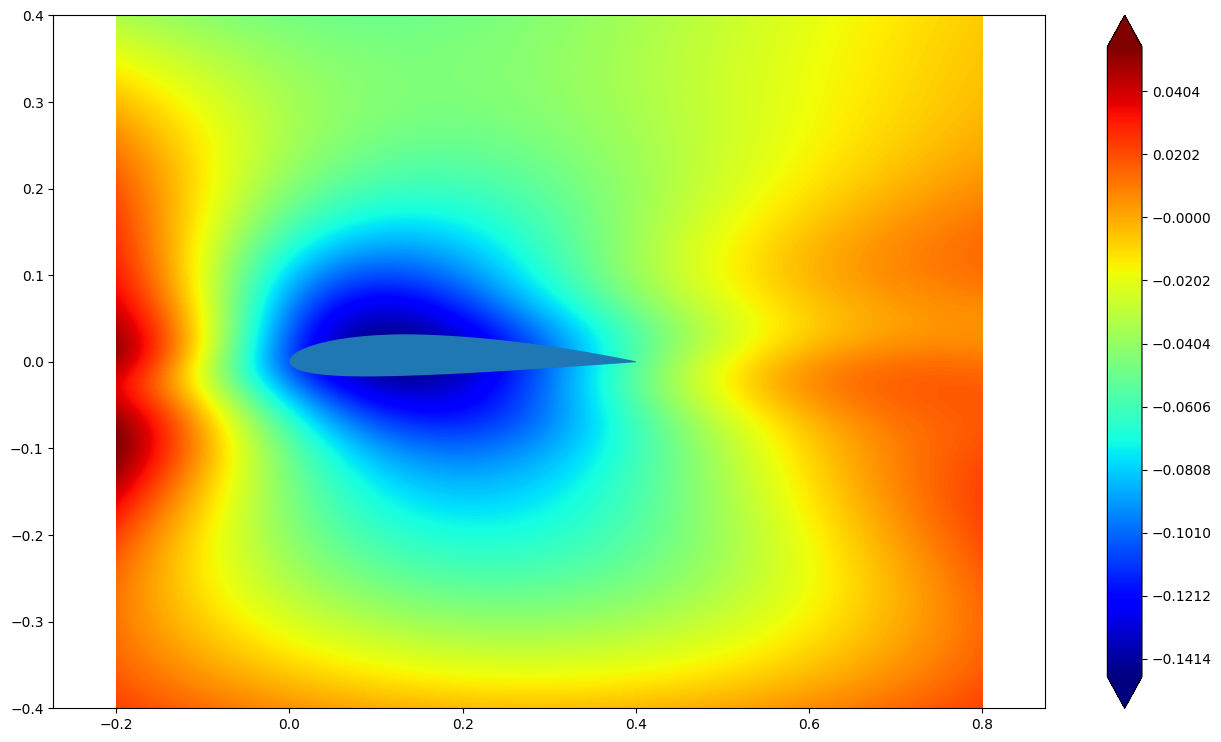

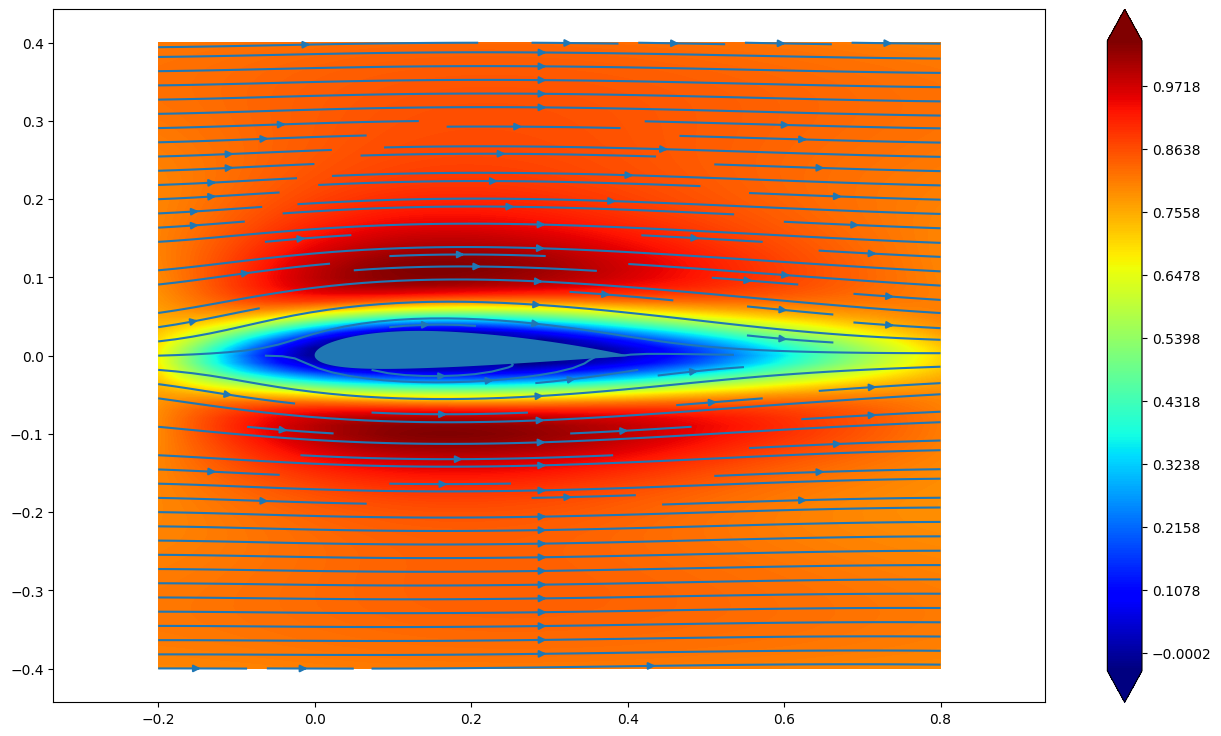

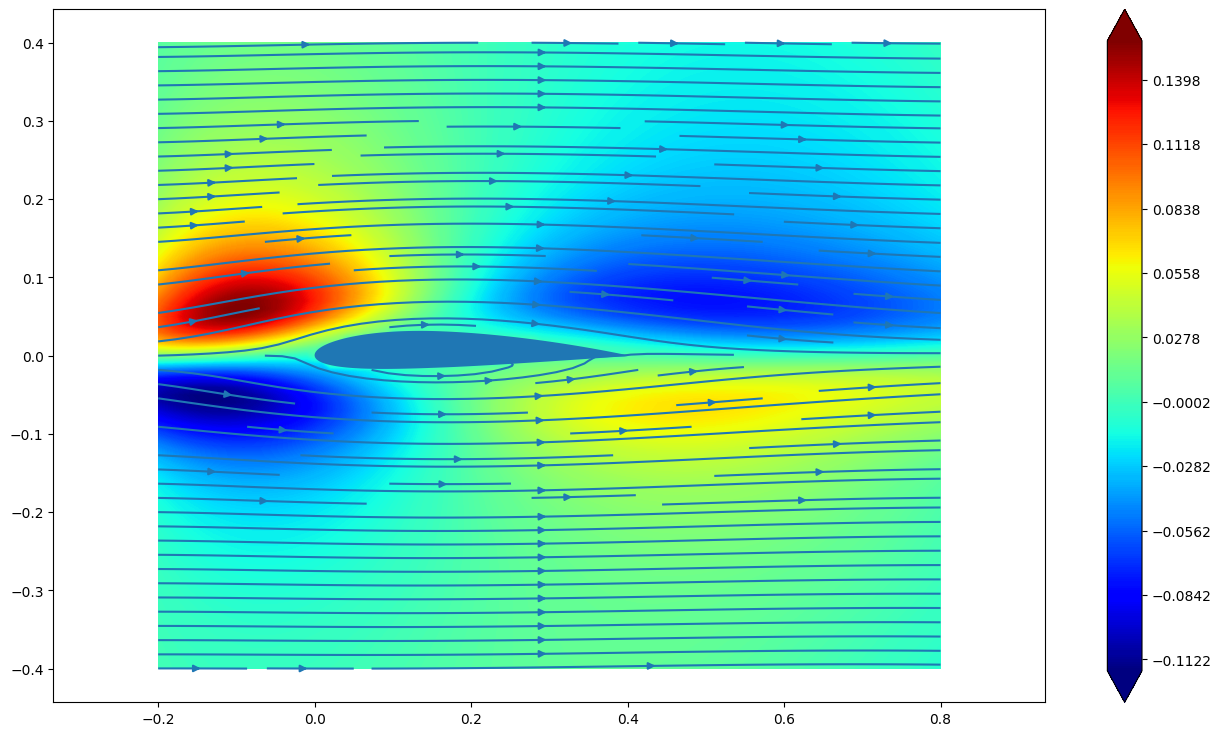

In [64]:
# Model predictions generation
u = model.predict(X, operator = navier_stokes_pdes.getU)
v = model.predict(X, operator = navier_stokes_pdes.getV)
p = model.predict(X, operator = navier_stokes_pdes.getP)

for i in range(len(X)):
   if airfoil_geom.inside(np.array([X[i]]))[0]:
       u[i] = 0.0
       v[i] = 0.0

u = u.reshape(len(y), len(x))
v = v.reshape(len(y), len(x))
p = p.reshape(len(y), len(x))

airfoil_plot = airfoil.get_boundary_points(150)

fig1, ax1 = plt.subplots(figsize = (16, 9))
#ax1.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(p.min(), p.max(), 0.001)
cnt1 = ax1.contourf(x, y, p, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig1.colorbar(cnt1)
plt.savefig(model_name + '/p.png')

fig2, ax2 = plt.subplots(figsize = (16, 9))
ax2.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(u.min(), u.max(), 0.001)
cnt2 = ax2.contourf(x, y, u, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig2.colorbar(cnt2)
plt.savefig(model_name + '/u.png')

fig3, ax3 = plt.subplots(figsize = (16, 9))
ax3.streamplot(x, y, u, v, density = 1.5)
clev = np.arange(v.min(), v.max(), 0.001)
cnt3 = ax3.contourf(x, y, v, clev, cmap = plt.cm.jet, extend='both')
plt.axis('equal')
plt.fill(airfoil_plot[:, 0], airfoil_plot[:, 1])
fig3.colorbar(cnt3)
plt.savefig(model_name + '/v.png')